# SQL Data Analysis with LLM

## Multi-Agents for SQL Data Analysis

**The SQL Data Analysis agent** we build in this tutorial is a multi-agent that can perform SQL queries on a database and optionally visualize the results. The agent combines 2 subagents:

1. **SQL Database Agent:** Query a database, perform basic data analysis, and return the results as a data frame.
2. **Data Visualization Agent:** Visualize the results if a user requests a plot.

This tutorial will show you how to connect up to a database and perform Data Analysis using SQL queries and visualizations, **all in one agent.** 

### Database

The database is the single-table fluid catalytic cracking unit (FCCU) dataset.

# Build SQL Data Analysis Agents

### Table of Contents

1. [Introduction](#introduction)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Connect to a SQL Database](#connect-to-a-sql-database)
5. [Create The Agent](#create-the-agent)
6. [Run the Agent](#run-the-agent)
7. [Response](#response)
    1. [SQL Query Code](#sql-query-code)
    2. [Pandas Data Frame From SQL Query](#pandas-data-frame-from-sql-query)
    3. [Python Pipeline Function](#python-pipeline-function)
8. [Make a Plot](#make-a-plot)

### Load Libraries

In [1]:
import sys
sys.path.append('..')

In [2]:
# * Libraries
import sqlalchemy as sql, pandas as pd, os

from langchain_openai import ChatOpenAI
from DAPCOR.multiagents import SQLDataAnalyst
from DAPCOR.agents import SQLDatabaseAgent, DataVisualizationAgent

### Setup AI and Logging

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [3]:
# load API and create llm object
MODEL    = "gpt-4o-mini"
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model = MODEL)
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x0000025FE2558800>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x0000025FE255A4E0>, root_client=<openai.OpenAI object at 0x0000025FE2413260>, root_async_client=<openai.AsyncOpenAI object at 0x0000025FE2558860>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

### Connect to a SQL Database

Next, let's connect to the FCCU SQL database. We will need to use a `sqlalchemy` connection to use the SQL Database Agent.

In [4]:
# Create the engine with the correct path
db_path = os.path.join("..", "data", "FCCU.db")
sql_engine = sql.create_engine(f"sqlite:///{db_path}")
conn = sql_engine.connect()

### Create The Agent

Run this code to create the agent with `SQLDataAnalyst()`. This will create a multi-agent that can perform SQL queries on a database and optionally visualize the results. This agent combines 2 subagents:

#### SQLDatabaseAgent

The `SQLDatabaseAgent` is a subagent that queries a database, performs basic data analysis, and returns the results as a data frame.

#### DataVisualizationAgent

The `DataVisualizationAgent` is a subagent that visualizes the results if a user requests a plot.

Run this code to create the multi-agent:

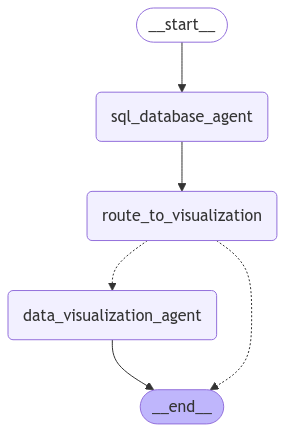

In [5]:
# Make the agent
LOG      = True
LOG_PATH = os.path.join("..", "logs/")

sql_data_analyst = SQLDataAnalyst(
    model = llm,
    sql_database_agent = SQLDatabaseAgent(
        model = llm,
        connection = conn,
        n_samples = 1,
        log = LOG,
        log_path = LOG_PATH,
        bypass_recommended_steps=False,
    ),
    data_visualization_agent = DataVisualizationAgent(
        model = llm,
        n_samples = 10,
        log = LOG,
        log_path = LOG_PATH,
    )
)

sql_data_analyst

### Viewing Subagents With xray

Keep in mind that this agent is actually a multi-agent that combines 2 subagents. We can view the subagents by running the following code:

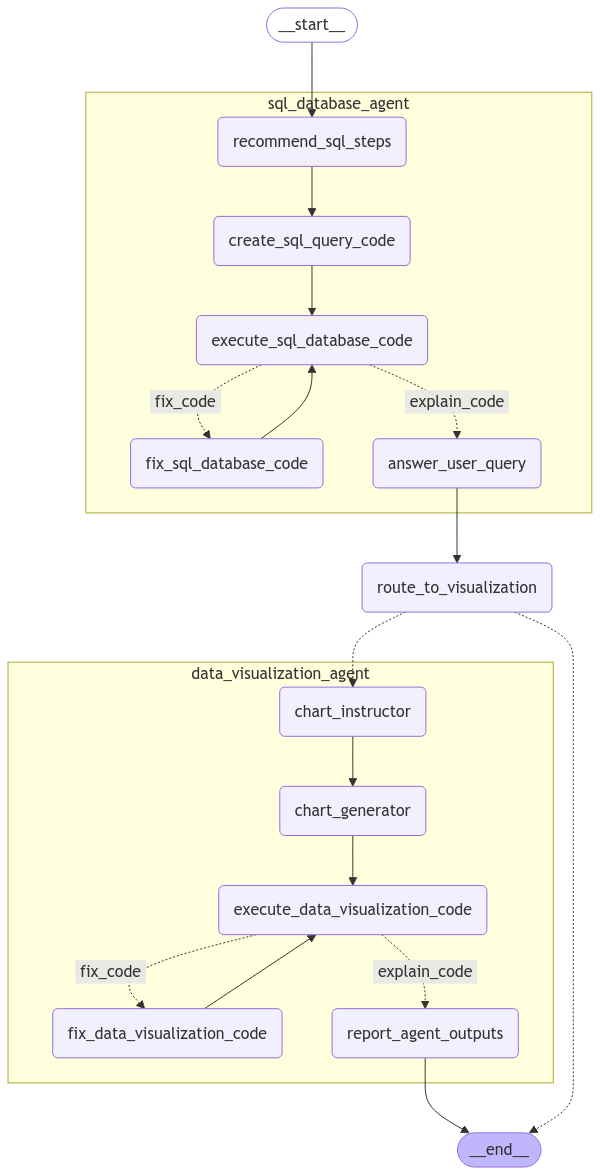

In [6]:
sql_data_analyst.show(xray=1)

## Run the Agent

The main inputs to the SQL DB Agent are:

- **user_instructions**: What actions you'd like to take on the SQL database. 

Let's start with a simple question that a user might want to know about the database:

## What tables are in the database?

In [7]:
sql_data_analyst.invoke_agent(
    user_instructions = "What tables are in the database?",
)

---SQL DATABASE AGENT----
    * RECOMMEND STEPS
    * CREATE SQL QUERY CODE
    * CREATE PYTHON FUNCTION TO RUN SQL CODE
      File saved to: ..\logs/sql_database.py
    * EXECUTING AGENT CODE ON SQL CONNECTION
    * GENERATE USER ANSWER


### Response

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [8]:
sql_data_analyst.get_state_keys()

['messages',
 'user_instructions',
 'sql_query_code',
 'sql_database_function',
 'data_sql',
 'data_raw',
 'plot_required',
 'data_visualization_function',
 'plotly_graph',
 'max_retries',
 'retry_count']

Not all fields will be filled if the agent did not need to use them.

- **sql_query_code**: The SQL query code that was generated by the agent.
- **sql_database_function**: The Python function that was generated by the SQL Database Agent.
- **data_sql**: The Pandas data frame that was generated by the agent.
- **data_visualization_function**: The Python function that was generated by the Data Visualization Agent.
- **plotly_graph**: The Plotly graph that was generated by the Data Visualization Agent.

#### SQL Query Code

In [9]:
sql_data_analyst.get_sql_query_code(markdown=True)

```sql
SELECT name FROM sqlite_master WHERE type='table';
```

#### Pandas Data Frame From SQL Query

In [10]:
sql_data_analyst.get_data_sql()

,name
0,historical_data


#### Python Pipeline Function

In [11]:
sql_data_analyst.get_sql_database_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: sql_database_agent
# Time Created: 2025-02-02 01:10:44


def sql_database_pipeline(connection):
    import pandas as pd
    import sqlalchemy as sql
    
    # Create a connection if needed
    is_engine = isinstance(connection, sql.engine.base.Engine)
    conn = connection.connect() if is_engine else connection

    sql_query = '''
    SELECT name FROM sqlite_master WHERE type='table';
    '''
    
    return pd.read_sql(sql_query, connection)
    
```

## A relatively more complicated user request

Let's make a plot of daily-averaged furnace temperature vs fresh feed flow. This will require a more complex SQL query and a Data Visualization. 

In [16]:
sql_data_analyst.invoke_agent(
    user_instructions = "Make a time plot of furnace temperature and fresh feed flow. Use distinct colors for each signal.",
    # user_instructions = "Make a plot of daily-averaged furnace temperature vs fresh feed flow",
)

---SQL DATABASE AGENT----
    * RECOMMEND STEPS
    * CREATE SQL QUERY CODE
    * CREATE PYTHON FUNCTION TO RUN SQL CODE
      File saved to: ..\logs/sql_database.py
    * EXECUTING AGENT CODE ON SQL CONNECTION
    * GENERATE USER ANSWER
---DATA VISUALIZATION AGENT----
    * CREATE CHART GENERATOR INSTRUCTIONS
    * CREATE DATA VISUALIZATION CODE
      File saved to: ..\logs/data_visualization.py
    * EXECUTING AGENT CODE
    * REPORT AGENT OUTPUTS


In [17]:
sql_data_analyst.get_plotly_graph()

The above graph is not easy to check if furnace temperature and feed flow changed in similar manner. It would have been good to plot scaled signals. In the next version of DAPCOR, we will see how we can include a Python analytic agent to our Graph that will process the SQL-queried data to bring the signals in the required form to create a meaningful visualization.

Let's check the sql query and the visualization code that was generated by LLM agents

In [18]:
sql_data_analyst.get_sql_database_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: sql_database_agent
# Time Created: 2025-02-02 01:11:28


def sql_database_pipeline(connection):
    import pandas as pd
    import sqlalchemy as sql
    
    # Create a connection if needed
    is_engine = isinstance(connection, sql.engine.base.Engine)
    conn = connection.connect() if is_engine else connection

    sql_query = '''
    SELECT timestamp, "Furnace temperature", "Fresh feed flow" 
FROM historical_data;
    '''
    
    return pd.read_sql(sql_query, connection)
    
```

In [19]:
sql_data_analyst.get_data_visualization_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: data_visualization_agent
# Time Created: 2025-02-02 01:11:42

def data_visualization(data_raw):
    import pandas as pd
    import numpy as np
    import json
    import plotly.graph_objects as go
    import plotly.io as pio





    # Convert timestamp to datetime
    data_raw['timestamp'] = pd.to_datetime(data_raw['timestamp'])

    # Create figure
    fig = go.Figure()

    # Add Furnace Temperature trace
    fig.add_trace(go.Scatter(
        x=data_raw['timestamp'],
        y=data_raw['Furnace temperature'],
        mode='lines+markers',
        name='Furnace Temperature',
        line=dict(color='#3381ff', width=0.65),
        hoverinfo='text',
        hovertext=data_raw['Furnace temperature'].astype(str),
    ))

    # Add Fresh Feed Flow trace
    fig.add_trace(go.Scatter(
        x=data_raw['timestamp'],
        y=data_raw['Fresh feed flow'],
        mode='lines+markers',
        name='Fresh Feed Flow',
        line=dict(color='#ff7f0e', width=0.65),
        hoverinfo='text',
        hovertext=data_raw['Fresh feed flow'].astype(str),
    ))

    # Update layout
    fig.update_layout(
        title='Furnace Temperature and Fresh Feed Flow Over Time',
        xaxis_title='Time',
        yaxis_title='Measurements',
        template='plotly_white',
        font=dict(size=8.8),
        title_font=dict(size=13.2)
    )

    # Update axes ticks font size
    fig.update_xaxes(tickfont=dict(size=8.8))
    fig.update_yaxes(tickfont=dict(size=8.8))

    # Add trendline (smoother)
    fig.add_trace(go.Scatter(
        x=data_raw['timestamp'],
        y=data_raw['Furnace temperature'].rolling(window=30).mean(),
        mode='lines',
        name='Furnace Temperature Trend',
        line=dict(color='#3381ff', width=2, dash='dash'),
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=data_raw['timestamp'],
        y=data_raw['Fresh feed flow'].rolling(window=30).mean(),
        mode='lines',
        name='Fresh Feed Flow Trend',
        line=dict(color='#ff7f0e', width=2, dash='dash'),
        showlegend=False
    ))

    # Convert the figure to JSON
    fig_json = pio.to_json(fig)
    fig_dict = json.loads(fig_json)
    
    return fig_dict
```